<div class="alert alert-info">
<h2> Исследование надежности заемщиков для кредитного отдела банка<a class="tocSkip"></h2>
    
<b>Цель:</b> выявить влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.
    
<b>Задача:</b> проанализировать платёжеспособность клиентов для погашения кредита в срок с учетом их семейного положения и количества детей. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

<b>Содержание:</b>
   1. Предобработка данных;
   2. Исследовательский анализ данных;
   5. Общие выводы.</div>

## Предобработка данных

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data = pd.read_csv('/datasets/data.csv')
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [3]:
#проверка основной информации о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
#проверка пропусков
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [5]:
# заполнила пропуски в столбце total_income медианным значением по каждому типу из столбца income_type
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

In [6]:
#заменила все отрицательные значения (аномалии) положительными с помощью метода abs()
data['days_employed'] = data['days_employed'].abs()

In [7]:
#Для каждого типа занятости выведила медианное значение трудового стажа days_employed в днях. 
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Поскольку исправить такие значения сложно, оставила их как есть.

In [8]:
# проверка уникальных значений столбца children
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [9]:
# удалила  два аномальных значения столбца children (20 и -1)
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [10]:
# заполнила пропуски в столбце days_employed медианными значениями по каждого типа занятости income_type.
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [11]:
#проверка пропусков
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [12]:
#изменение типа данных в total_income
data['total_income'] = data['total_income'].astype(int)

In [13]:
#проверка названий в столбце education.
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [14]:
#приведение к нижнему регистру названий в столбце education
data['education'] = data['education'].str.lower()

In [15]:
# проверка на явные дубликаты
data.duplicated().sum()

71

In [16]:
# удаление явных дубликатов
data = data.drop_duplicates()
data.duplicated().sum()

0

In [17]:
# категоризация данных доходов
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass
data['total_income_category'] = data['total_income'].apply(categorize_income)
data['total_income_category']

0        B
1        C
2        C
3        B
4        C
        ..
21520    B
21521    C
21522    C
21523    B
21524    C
Name: total_income_category, Length: 21331, dtype: object

In [18]:
#перечень уникальных целей взятия кредита
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [19]:
# категоризация целей взятия кредита
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследовательский анализ данных

### Проверка наличия зависимости между количеством детей и возвратом кредита в срок

In [20]:
#сводная таблица количества детей, кредита и вероятности просрочки в каждой из групп
data_children = data.groupby('children').agg({'debt': ['count', 'mean']}).reset_index()
data_children = data_children.style.format({('debt', 'mean'): '{:.2%}'})
data_children.columns = ['children', 'debt', 'mean' ]
data_children

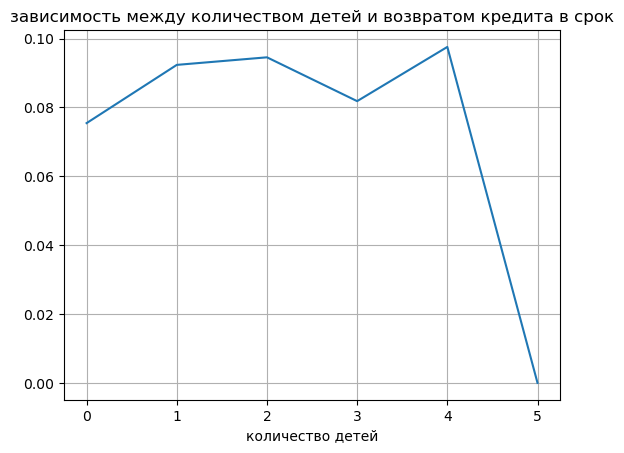

In [21]:
# визуализации данных по среднему значению
data.groupby('children')['debt'].mean().plot(grid=True).set(title = "зависимость между количеством детей и возвратом кредита в срок", xlabel ='количество детей');

**Вывод:**  Если смотреть на процентное соотношение, то группа клиентов без детей берет больше всего долгов, но имеет больше вероятность что они вернут их в срок. В тоже время чем больше у клиента детей, тем больше вероятность просрочки. Однако, тогда здесь выделяется группа клиентов с 5-мю детьми, поскольку их всего 9. Такие данные нерепрезентативные. Также выбиваются группы с 3-мя и 4-я детьми, также с небольшим количеством клиентов. Тем не менее, можно увидеть небольшую зависимость у группы «без детей» и с 1-м и 2-мя детьми.

### Проверка наличия зависимости между семейным положением и возвратом кредита в срок

In [22]:
#сводная таблица по семейному положению и вероятности просрочки в каждой из групп
data_family=  data.groupby('family_status').agg({'dob_years': ['mean']})
display(data_family.style.format({('debt', 'mean'): '{:.2%}'}))

,dob_years
,mean
family_status,
Не женат / не замужем,38.368026
в разводе,45.561817
вдовец / вдова,56.501577
гражданский брак,42.067731
женат / замужем,43.558519


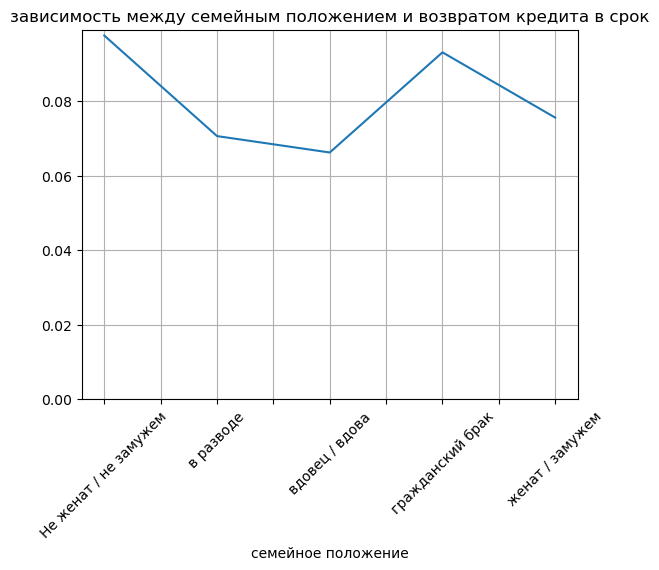

In [23]:
# визуализации данных по среднему значению
data.groupby('family_status')['debt'].mean().plot(grid=True, rot=45, ylim=0).set(title = "зависимость между семейным положением и возвратом кредита в срок", xlabel ='семейное положение');

**Вывод:** Большое количество замужних/женатых клиентов имеют большую вероятность вернуть кредиты в срок. Скорее всего за счет помощи со стороны мужа/жены. А группы не замужних и состоящих в гражданском браке меньше всего рассчитывают на стороннюю помощь и тем самым имеют большую вероятность просрочки кредитов.
Также было интересно посмотреть почему клиенты в разводе и клиенты вдовцы меньше всего берут кредиты и с большей вероятностью возвращают их в срок. Гипотезой была вероятность, что клиенты старше возрастом и имеют меньше желаний и целей для взятия кредитов. Дополнительные расчеты показали, что их средние возрасты за 45 и 56 лет, что вполне может доказывать гипотезу. Таким образом, зависимость между семейным положением и возвратом кредита в срок есть.

### Проверка наличия зависимости между уровнем дохода и возвратом кредита в срок

In [24]:
#сводная таблица уровня дохода, кредита и вероятности просрочки в каждой из групп
data_income = data.groupby('total_income_category').agg({'debt': ['count', 'mean']})
display(data_income.style.format({('debt', 'mean'): '{:.2%}'})) 

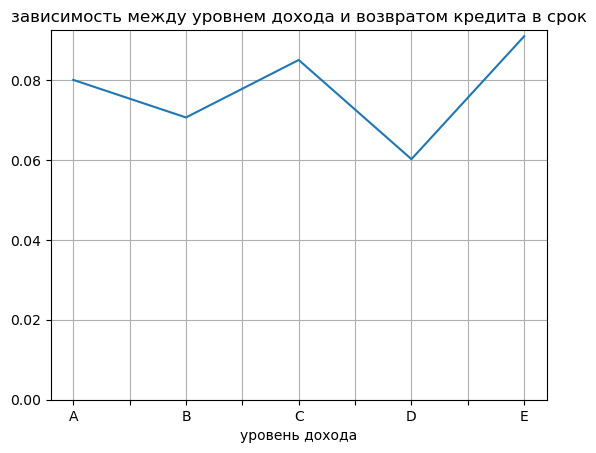

In [25]:
# визуализации данных по среднему значению
data.groupby('total_income_category')['debt'].mean().plot(grid=True,ylim=0).set(title = "зависимость между уровнем дохода и возвратом кредита в срок", xlabel ='уровень дохода');

**Вывод:**  Если смотреть на количество, то здесь выделяются 2 группы с наименьшем количеством с группы с самым большим доходом «А», самым наименьшем «Е» и с доходом «D». Такие данные нерепрезентативны и не будут учитываться при формировании зависимости. Остальные 2 группы данных показывают, что группа "С", где доход варьируется от 50001 до 200000, больше всего берет кредитов в долг и имеет меньшую вероятность на возврат его в срок. А клиенты с категории «В» имеют в три раза меньше должников и больше вероятность возврата кредита в срок. Тем самым, уровень дохода зависит от возврата кредита в срок.

### Проверка как разные цели кредита влияют на его возврат в срок

In [26]:
#сводная таблица уровня дохода, кредита и вероятности просрочки в каждой из групп
data_purpose = data.groupby('purpose_category').agg({'debt': ['count', 'mean']})
display(data_purpose.style.format({('debt', 'mean'): '{:.2%}'}))

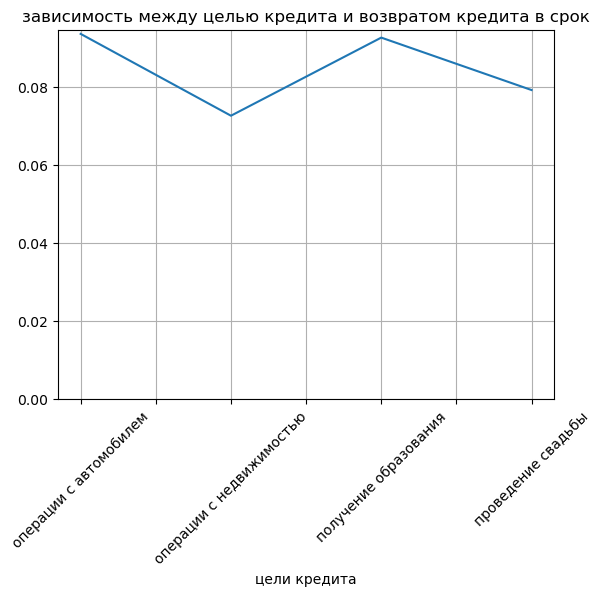

In [27]:
data.groupby('purpose_category')['debt'].mean().plot(grid=True, rot=45, ylim=0).set(title = "зависимость между целью кредита и возвратом кредита в срок", xlabel ='цели кредита');


**Вывод:** Основной целью взятия кредитов по количеству должников является «операция с недвижимостью» и она имеют большую вероятность выплаты кредита по нему в срок. Меньше всего вероятности выплаты в срок были цели по «операции с автомобилем» и по «получению образования». 

## Общие выводы

- На основе полученных данных можно увидеть определенное влияние семейного положения и количества детей клиента на погашение кредита в срок. Стоит обратить внимание на замужних/женатых клиентов и клиентов без детей, поскольку они чаще берут кредиты и чаще оплачивают их вовремя. 
- Другой фактор для учета может быть уровень дохода, который также показал, что клиенты со средним достатком берут больше кредитов, но с меньшей вероятностью оплаты в срок. В этом случае больше интересны клиенты с доходом выше среднего. 
- Также для одобрения кредита будет лучше ориентироваться на цель займа как «операции с недвижимостью». 
- При формировании модели кредитного скоринга важно учесть, что при подсчете были выявлены нерепрезентативные данные (небольшое количество), которые не были учтены для выявления зависимости.